In [1]:
import numpy as np

from speechbrain.lobes.beamform_multimic import DelaySum_Beamformer
import os
import glob
from pathlib import Path
import soundfile as sf
import torch
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
# from speechbrain.processing.features import (
#     STFT,
#     ISTFT,
#     Complex_STFT,
# )
from pydub import AudioSegment
# from beamformer import 

/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
 in /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


In [3]:
beamformer=DelaySum_Beamformer()
# stft = Complex_STFT(sample_rate=16000)
# istft = ISTFT(sample_rate=16000)

In [2]:
meeting_folder = "/Users/ccui/Desktop/DATA/AMI_sample/amicorpus/TS3003a/audio"
wavs = os.listdir(meeting_folder)
array1_list = []
# array2_list = []

for wav in wavs:
    mic_type = wav.split(".")[1]
    wav_path = os.path.join(meeting_folder, wav)
    if "Array1" in mic_type:
        # print(wav_path)
        # array_path_list.append(str(Path(wav)))
        array_np, fs = sf.read(
            wav_path,
            dtype="float32",
        )
        # array = torch.from_numpy(array_np).unsqueeze(0)

        array1_list.append(array_np[..., np.newaxis])
    # elif "estimate" in mic_type:
    #     pretrained, fs = sf.read(
    #         wav_path,
    #         dtype="float32",
    #     )
    # elif mic_type == "s1":
    #     source, fs = sf.read(
    #         wav_path,
    #         dtype="float32",
    #     )
# array1_list = torch.cat(array1_list, 0).float()
array1_list = np.concatenate(array1_list, axis=1)
# array2_list = torch.cat(array2_list, 0).float()
# array1_list = array1_list[:, 16000 * 9 : 16000 * 15]
# array2_list = array2_list[:, 16000 * 9 : 16000 * 15]
print(array1_list.shape)
# print(array2_list.shape)

(24090282, 8)


In [3]:
# Sampling rate and desired time interval
sampling_rate = 16000
start_time = 15  # in seconds
end_time = 20  # in seconds

# Calculate the corresponding indices
start_index = start_time * sampling_rate
end_index = end_time * sampling_rate
extracted_audio = array1_list[start_index:end_index,:]
print(extracted_audio.shape)

(80000, 8)


In [23]:
Audio(data=extracted_audio[:,0], rate=16000)

In [4]:
four_micro_channels = extracted_audio[:, [0, 2, 4, 6]]
print(four_micro_channels.shape)

(80000, 4)


In [5]:
from beamformer.util import get_3dim_spectrum_from_data, spec2wav


def apply_beamformer(beamformer, complex_spectrum, SAMPLING_FREQUENCY, FFT_LENGTH, FFT_SHIFT):
    number_of_channels, number_of_frames, number_of_bins = np.shape(complex_spectrum)
    enhanced_spectrum = np.zeros((number_of_frames, number_of_bins), dtype=np.complex64)
    for f in range(0, number_of_bins):
        # print("beamformer[:, f].shape")
        # print(beamformer[:, f].shape)
        # print("complex_spectrum[:, :, f].shape")
        # print(complex_spectrum[:, :, f].shape)
        enhanced_spectrum[:, f] = np.matmul(
            np.conjugate(beamformer[:, f]).T, complex_spectrum[:, :, f]
        )
        # print("np.conjugate(beamformer[:, f]).T.shape")
        # print(np.conjugate(beamformer[:, f]).T.shape)
    return spec2wav(
        enhanced_spectrum,
        SAMPLING_FREQUENCY,
        FFT_LENGTH,
        FFT_LENGTH,
        FFT_SHIFT,
    )


def get_enhenced(multi_channels_data, beamformer):
    SAMPLING_FREQUENCY = 16000
    FFT_LENGTH = 512
    FFT_SHIFT = 256
    # MIC_ANGLE_VECTOR = np.arange(8, dtype="float32") * (360 / 8) + 0
    # MIC_DIAMETER = 0.15

    complex_spectrum, _ = get_3dim_spectrum_from_data(
        multi_channels_data, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH
    )

    enhanced_speech = apply_beamformer(
        beamformer, complex_spectrum, SAMPLING_FREQUENCY, FFT_LENGTH, FFT_SHIFT
    )
    return enhanced_speech

In [6]:
# four_micro_channels = np.array(four_micro_channels)
# print(four_micro_channels.shape[0])
four_response = np.load("save/4angle_from337.npy", allow_pickle=True)
sig_4 = torch.zeros(len(four_response), four_micro_channels.shape[0])
for angle, response_angle in enumerate(four_response):
    enhanced_speech = get_enhenced(four_micro_channels, response_angle)
    sig_4[angle][: len(enhanced_speech)] = torch.from_numpy(enhanced_speech)
sig_4 = np.array(sig_4)

eight_response = np.load("save/8ch_4angle_from337.npy", allow_pickle=True)
sig_8 = torch.zeros(len(eight_response), extracted_audio.shape[0])
for angle, response_angle in enumerate(eight_response):
    enhanced_speech = get_enhenced(extracted_audio, response_angle)
    sig_8[angle][: len(enhanced_speech)] = torch.from_numpy(enhanced_speech)
sig_8 = np.array(sig_8)

In [7]:
sig_4 = (sig_4 / np.max(np.abs(sig_4))) * max(abs(extracted_audio[:, 0]))
sig_8 = (sig_8 / np.max(np.abs(sig_8))) * max(abs(extracted_audio[:, 0]))

In [37]:
print(np.max(np.abs(np.array(sig_4[0]))).shape)

()


In [36]:
print(sig_4[0].shape)

torch.Size([80000])


In [5]:
meeting_folder = "/Users/ccui/Desktop/POC/asteroid_results/AMIx/TAC/joint/2ch_10_jeanzay"
wavs = os.listdir(meeting_folder)
array1_list = []
# array2_list = []

for wav in wavs:
    meeting = wav.split("_")[-2]
    mic_type = wav.split("_")[-1]
    wav_path = os.path.join(meeting_folder, wav)
    if meeting =="7":
        # if "mix" in mic_type:
        #     # print(wav_path)
        #     # array_path_list.append(str(Path(wav)))
        #     array_np, fs = sf.read(
        #         wav_path,
        #         dtype="float32",
        #     )
        #     array = torch.from_numpy(array_np).unsqueeze(0)
        #     array1_list.append(array)
        if "source1Est" in mic_type:
            neural, fs = sf.read(
                wav_path,
                dtype="float32",
            )
        # elif mic_type == "source1.wav":
        #     source, fs = sf.read(
        #         wav_path,
        #         dtype="float32",
            # )
# array1_list = torch.cat(array1_list, 0).float()
# array2_list = torch.cat(array2_list, 0).float()
# array1_list = array1_list[:, 16000 * 9 : 16000 * 15]
# array2_list = array2_list[:, 16000 * 9 : 16000 * 15]
# print(array1_list.shape)
# print(array2_list.shape)

In [8]:
wav_path = "/Users/ccui/Desktop/speechbrain/recipes/AMI/ASR/data_processing/speech_enhanced.wav"
neural, fs = sf.read(
    wav_path,
    dtype="float32",
)

In [9]:
neural = np.array([(neural / np.max(np.abs(neural))) * max(abs(array_np))], np.float32).squeeze(0)

In [13]:
Audio(data=neural, rate=16000)

In [7]:
def beamforming(signal):
    batch = signal.permute(1,0).unsqueeze(0)
    beamformed_array1=beamformer(batch)
    beamformed_array1=beamformed_array1.squeeze(-1).squeeze(0)
    return beamformed_array1

In [8]:
beamformed_array1 = beamforming(array1_list)


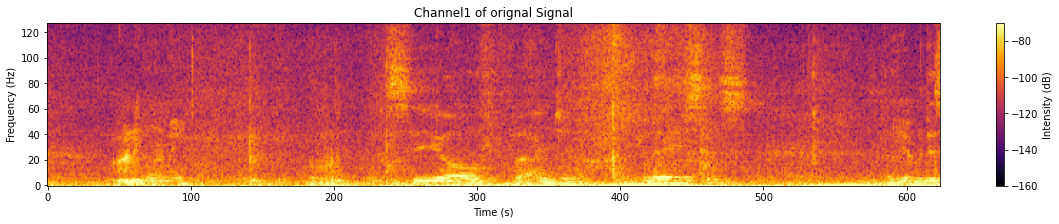

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/var/folders/l5/9kglh8tx5nb_wn200vv8zgwh00mc7h/T/ipykernel_6291/4239601138.py:7: RuntimeWarning: divide by zero encountered in log10
  sxx = 10 * np.log10(Sxx_masked)


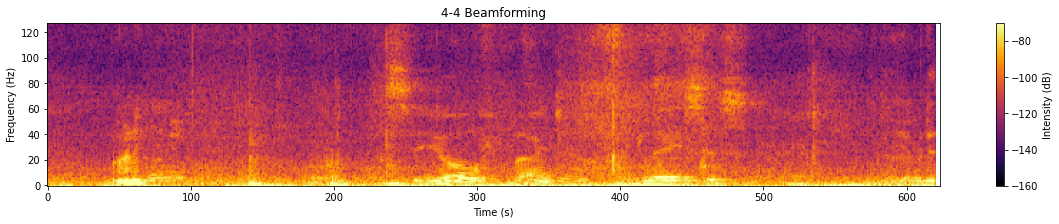

NameError: name 'neural' is not defined

In [40]:
def get_spect(signal, title):
    plt.figure(figsize=(20, 3))
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)
    # norm = Normalize(vmin=-150, vmax=-60)
    # plt.imshow(sxx, aspect='auto', cmap='inferno', vmin=-150, vmax=-60)
    plt.imshow(sxx, aspect="auto", cmap="inferno", vmin=-160, vmax=-70)
    plt.gca().invert_yaxis()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.colorbar(label="Intensity (dB)")
    plt.show()


get_spect(extracted_audio[:,0], "Channel1 of orignal Signal")
get_spect(sig_4[0], "4-4 Beamforming")
get_spect(neural, "Neural Beamforming")
get_spect(source, "source")

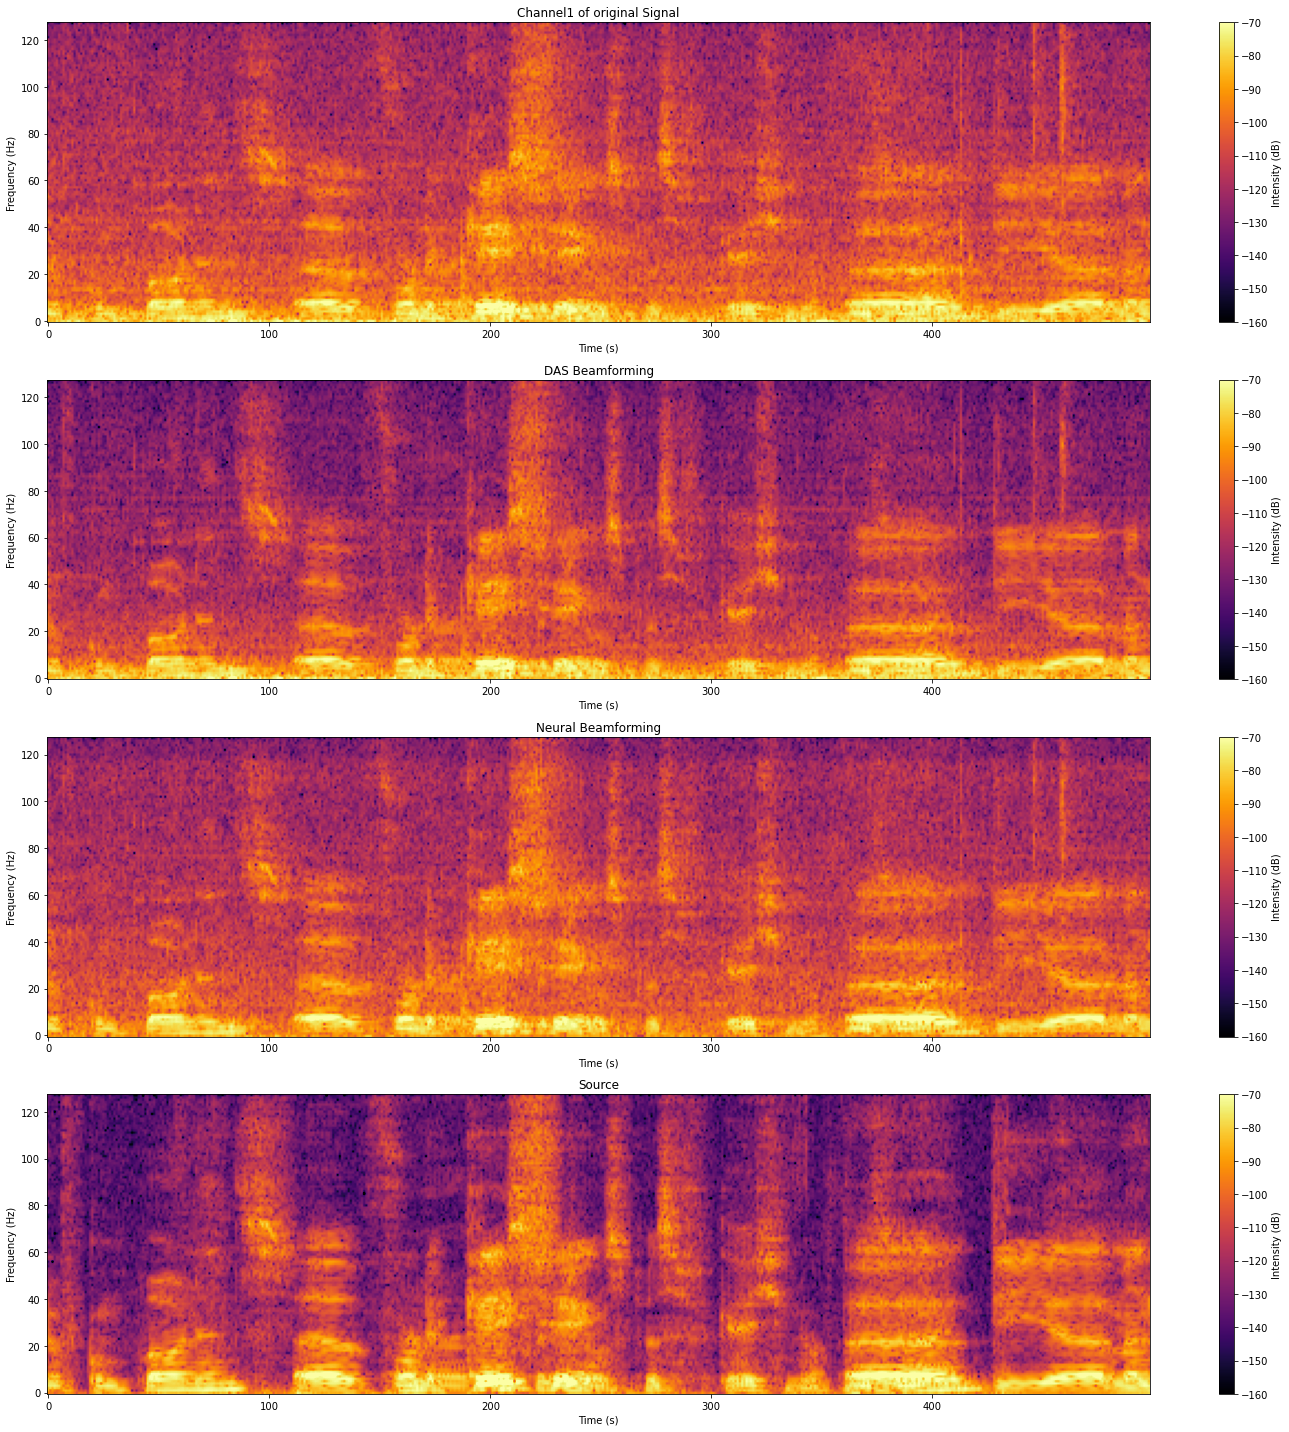

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-160, vmax=-70)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    return im


# Create a 4-row plot
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# Plot each spectrogram on a separate row
im1 = get_spect(array1_list[0], "Channel1 of original Signal", axes[0])
im2 = get_spect(beamformed_array1, "DAS Beamforming", axes[1])
im3 = get_spect(neural, "Neural Beamforming", axes[2])
im4 = get_spect(source, "Source", axes[3])

# Adjust layout to prevent clipping of axis labels
plt.tight_layout()

# Add colorbars to the right of the plots
cbar1 = plt.colorbar(im1, ax=axes[0], label="Intensity (dB)")
cbar2 = plt.colorbar(im2, ax=axes[1], label="Intensity (dB)")
cbar3 = plt.colorbar(im3, ax=axes[2], label="Intensity (dB)")
cbar4 = plt.colorbar(im4, ax=axes[3], label="Intensity (dB)")

# Show the plot
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/var/folders/l5/9kglh8tx5nb_wn200vv8zgwh00mc7h/T/ipykernel_88227/2462064563.py:11: RuntimeWarning: divide by zero encountered in log10
  sxx = 10 * np.log10(Sxx_masked)


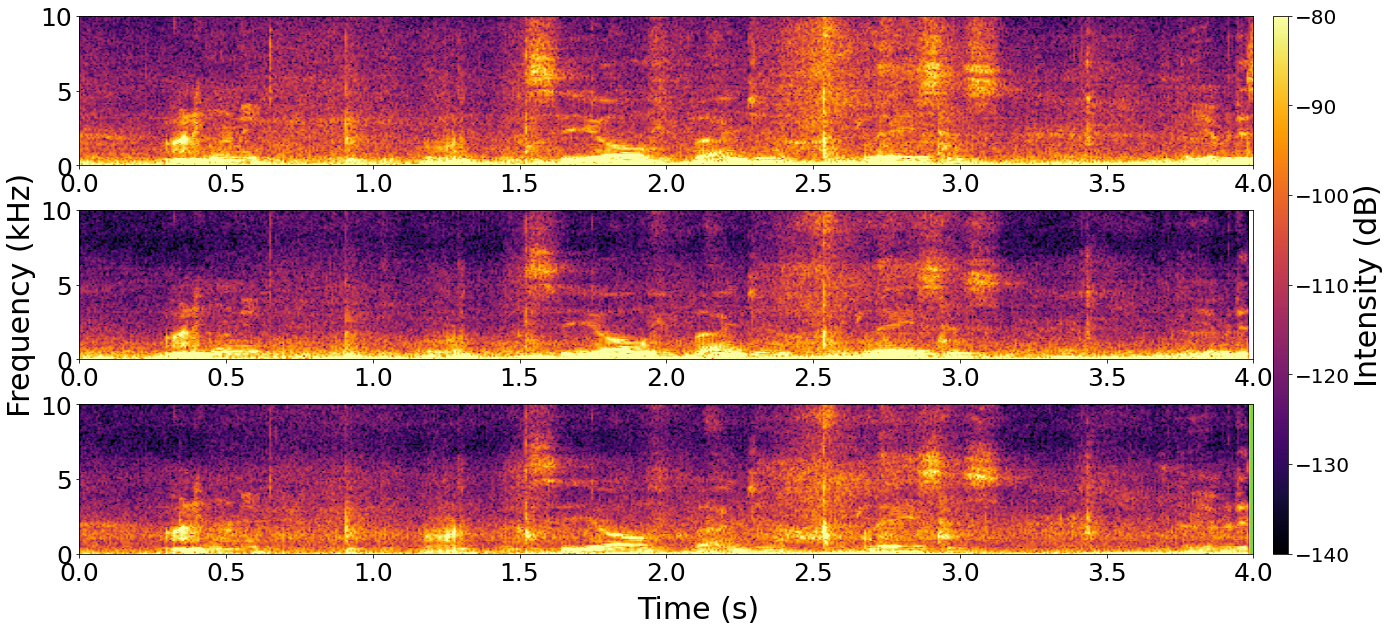

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-140, vmax=-80, extent=[0, 4, 10, 0])
    ax.invert_yaxis()
    ax.set_title(title, fontsize=39)
    # ax.set_xlabel("Time (s)", fontsize=25)
    # ax.set_ylabel("Frequency (Hz)", fontsize=25)
    ax.tick_params(axis="both", labelsize=25)
    return im


# Create a 4-row plot with a shared colorbar
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(3, 2, width_ratios=[19.5, 0.5])  # Add an extra column for the colorbar

# Plot each spectrogram on a separate row
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[2, 0])
# ax4 = plt.subplot(gs[3, 0])

# im1 = get_spect(array1_list[0], "Channel 1 of the original signal", ax1)
# # im2 = get_spect(beamformed_array1, "Signal after DAS Beamforming", ax2)
# im3 = get_spect(neural, "Signal after Joint Trained Neural Beamforming", ax2)
# im4 = get_spect(source, "Ground truth (aligned Headset)", ax3)
idx=0
im1 = get_spect(extracted_audio[:, idx], "", ax1)
# im2 = get_spect(beamformed_array1, "", ax2)
im3 = get_spect(sig_4[idx], "", ax2)
im4 = get_spect(sig_8[idx], "", ax3)

# Set a common xlabel and ylabel
fig.text(0.5, 0.001, "Time (s)", ha="center", fontsize=30)  # Common xlabel
fig.text(
    0.02, 0.5, "Frequency (kHz)", va="center", rotation="vertical", fontsize=30
)  # Common ylabel


# Adjust layout to prevent clipping of axis labels and move the subplots inward
plt.subplots_adjust(left=0.07, right=0.99, top=0.93, bottom=0.1, hspace=0.3)


# Add a common colorbar to the right of the plots
cax = plt.subplot(gs[:, 1])
cbar = plt.colorbar(im4, cax=cax, label="Intensity (dB)")

# Manually adjust the position of the colorbar
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0 - 0.07, cax_pos.y0, cax_pos.width * 0.5, cax_pos.height])

cbar.ax.yaxis.label.set_fontsize(30)
# Increase font size for colorbar
cbar.ax.tick_params(labelsize=20)
# Show the plot
plt.savefig("save/data_inv_sig.png", bbox_inches="tight")
plt.show()

/var/folders/l5/9kglh8tx5nb_wn200vv8zgwh00mc7h/T/ipykernel_6291/2971644279.py:11: RuntimeWarning: divide by zero encountered in log10
  sxx = 10 * np.log10(Sxx_masked)


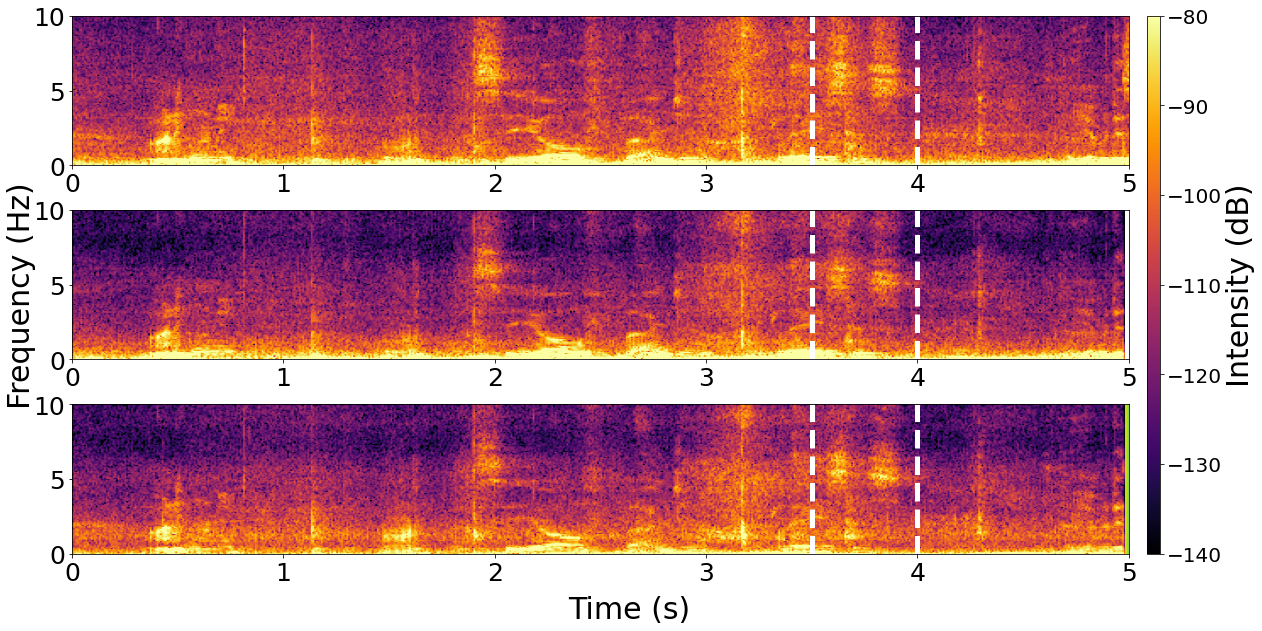

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


def get_spect(signal, title, ax):
    # Compute the spectrogram
    Sxx, frequencies, _, _ = plt.specgram(signal, Fs=16000)
    mask = frequencies > 0
    Sxx_masked = Sxx[mask, :]
    sxx = 10 * np.log10(Sxx_masked)

    # Plot the spectrogram on the specified axis
    im = ax.imshow(sxx, aspect="auto", cmap="inferno", vmin=-140, vmax=-80, extent=[0, 5, 10, 0])
    ax.invert_yaxis()
    ax.set_title(title, fontsize=39)
    # ax.set_xlabel("Time (s)", fontsize=25)
    # ax.set_ylabel("Frequency (Hz)", fontsize=25)
    ax.tick_params(axis="both", labelsize=25)
    return im


# Create a 4-row plot with a shared colorbar
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(3, 2, width_ratios=[19.5, 0.5])  # Add an extra column for the colorbar

# Plot each spectrogram on a separate row
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[2, 0])

# ax1.axvline(x=1.45, linestyle="--", color="white", linewidth=5, label="Angle 377°")
# ax1.axvline(x=1.7, linestyle="--", color="white", linewidth=5, label="Angle 22°")
ax1.axvline(x=3.5, linestyle="--", color="white", linewidth=5, label="Angle 377°")
ax1.axvline(x=4, linestyle="--", color="white", linewidth=5, label="Angle 22°")

# ax2.axvline(x=1.45, linestyle="--", color="white", linewidth=5, label="Angle 377°")
# ax2.axvline(x=1.7, linestyle="--", color="white", linewidth=5, label="Angle 22°")
ax2.axvline(x=3.5, linestyle="--", color="white", linewidth=5, label="Angle 377°")
ax2.axvline(x=4, linestyle="--", color="white", linewidth=5, label="Angle 22°")

# ax3.axvline(x=1.45, linestyle="--", color="white", linewidth=5, label="Angle 377°")
# ax3.axvline(x=3.2, linestyle="--", color="white", linewidth=5, label="Angle 22°")

ax3.axvline(x=3.5, linestyle="--", color="white", linewidth=5, label="Angle 377°")
ax3.axvline(x=4, linestyle="--", color="white", linewidth=5, label="Angle 22°")

# ax4 = plt.subplot(gs[3, 0])

# im1 = get_spect(array1_list[0], "Channel 1 of the original signal", ax1)
# # im2 = get_spect(beamformed_array1, "Signal after DAS Beamforming", ax2)
# im3 = get_spect(neural, "Signal after Joint Trained Neural Beamforming", ax2)
# im4 = get_spect(source, "Ground truth (aligned Headset)", ax3)
idx = 0
im1 = get_spect(extracted_audio[:, idx], "", ax1)
# im2 = get_spect(beamformed_array1, "", ax2)
im3 = get_spect(sig_4[idx], "", ax2)
im4 = get_spect(sig_8[idx], "", ax3)

# Set a common xlabel and ylabel
fig.text(0.5, 0.001, "Time (s)", ha="center", fontsize=30)  # Common xlabel
fig.text(
    0.02, 0.5, "Frequency (Hz)", va="center", rotation="vertical", fontsize=30
)  # Common ylabel


# Adjust layout to prevent clipping of axis labels and move the subplots inward
plt.subplots_adjust(left=0.07, right=0.99, top=0.93, bottom=0.1, hspace=0.3)


# Add a common colorbar to the right of the plots
cax = plt.subplot(gs[:, 1])
cbar = plt.colorbar(im4, cax=cax, label="Intensity (dB)")

# Manually adjust the position of the colorbar
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0 - 0.07, cax_pos.y0, cax_pos.width * 0.5, cax_pos.height])

cbar.ax.yaxis.label.set_fontsize(30)
# Increase font size for colorbar
cbar.ax.tick_params(labelsize=20)
# Show the plot
plt.savefig("save/data_inv_sig.png", bbox_inches="tight")
plt.show()

In [31]:
print(neural[start_time:end_time].shape)

(0,)


In [77]:
print(sig_4.shape)

(4, 80000)
